<a href="https://colab.research.google.com/github/EmmanuelADAM/IntelligenceArtificiellePython/blob/master/memoryNN_rnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exemple de RNN

Cet exemple montre qu'un réseau de type RNN peut apprendre à prédire une valeur, à partir de valeurs précédentes.

1. des courbes sont générées (1000 courbes contenant 10 valeurs, (1 valeur par temps (top))).
2. pour chaque courbe, le réseau apprend à prédire la 10e valeurs  à partir des 9 valeurs précédentes.
    - il propose une valeur, mesure son erreur, puis corrige éventuellement ses poids
    - le même poids est appris pour chaque temps de chaque séquence 
    - la correction des poids est faite en revenant sur les temps de la séquence
    - pour les longues séquences, les premières valeurs sont alors moins bien "apprises"
3. un test illustre la qualité de l'apprentissage    

In [1]:
# les libraries
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, SimpleRNN, Dense
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt

In [2]:
# definir le démarrage du "hasard" pour la reproductibilité
np.random.seed(42)
tf.random.set_seed(42)

In [3]:
# fonction qui génère les séries de données
def generate_time_series_data(num_samples, sequence_length=10):
    # Genere une séquence dont chaque valeur dépend des 3 précédentes
    data = np.zeros((num_samples, sequence_length))
    for i in range(num_samples):
        x = np.random.rand()
        for j in range(sequence_length):
            if j < 3:
                data[i, j] = x + np.random.normal(0, 0.05)
                x = data[i, j]
            else:
                # Next value is a function of previous 3 values + noise
                data[i, j] = 0.9 * data[i, j-1] - 0.2 * data[i, j-2] + 0.4 * data[i, j-3] + np.random.normal(0, 0.05)
    
    # les entrées (toutes les valeurs sauf la dernière)
    X = data[:, :-1]
    # les sorties (les dernières valeurs)
    y = data[:, -1]
    
    # Reshape X to be [samples, time steps, features]
    X = X.reshape(X.shape[0], X.shape[1], 1)
    
    return X, y

In [4]:
# generer les données
num_samples = 1000
sequence_length = 10
X_data, y_data = generate_time_series_data(num_samples, sequence_length)

# séparer entrer donnees de test et d'apprentissage
train_size = int(0.8 * num_samples)
X_train, X_test = X_data[:train_size], X_data[train_size:]
y_train, y_test = y_data[:train_size], y_data[train_size:]

In [5]:
import matplotlib.pyplot as plt

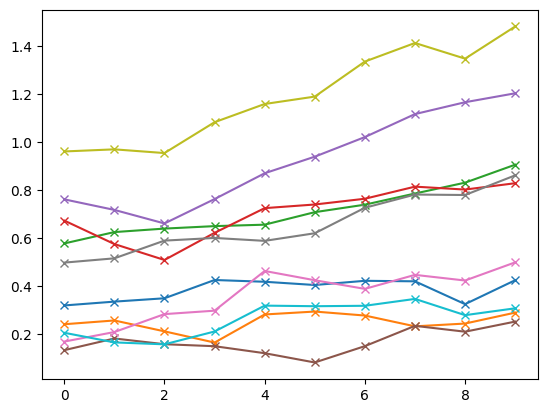

In [6]:
# dessin de quelques courbes à apprendre
Xs = range(X_train.shape[1]+1)
for i in range(10):
    l = []
    for j in range(X_train.shape[1]):
        l.append(X_train[i][j][0])
    l.append(y_train[i])
    plt.plot(Xs, l,  '-x')

In [7]:
# Création du RNN simple
def create_rnn_model(nb_neurons=16, format_entree=(9, 1)):
    model = Sequential([
        # Ajouter une couche d'entrée avec la bonne taille (vecteur de 9 elements)
        Input(shape=format_entree),
        # Ajouter une couche de RNN avec nb_neurons neurones
        SimpleRNN(nb_neurons, activation='tanh',  name='couche_rnn'),
        # et un couche de sortie de taille 1 (1 sortie attendue)
        Dense(1, name='couche_de_sortie')
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

In [8]:

# creer le modele
model = create_rnn_model(nb_neurons=32)

# affichage des détails du modèle
print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ couche_rnn (SimpleRNN)          │ (None, 32)             │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ couche_de_sortie (Dense)        │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,121 (4.38 KB)

 Trainable params: 1,121 (4.38 KB)

 Non-trainable params: 0 (0.00 B)

None


In [9]:

# Entrainer le modèle
history = model.fit(X_train, y_train, 
                    epochs=50, 
                    batch_size=32, 
                    validation_data=(X_test, y_test),
                    verbose=1)

Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.2832 - val_loss: 0.0173
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0195 - val_loss: 0.0106
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0099 - val_loss: 0.0078
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0079 - val_loss: 0.0066
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0070 - val_loss: 0.0060
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0064 - val_loss: 0.0056
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0060 - val_loss: 0.0053
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0057 - val_loss: 0.0051
Epoch 9/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0055 - val_loss: 0.0050
Epoch 10/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0053 - val_loss: 0.0048
Epoch 11/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0051 - val_loss: 0.0047
Epoch 12/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0050 - val_l

In [10]:
# Visualiser la courbe des erreurs
def plot_training_history(history):
    """
    Plot the training and validation loss during model training.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss During Training')
    plt.ylabel('Mean Squared Error')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid(True)
    # In a real application, you would save this figure
    print("In a real application, this would display a plot of training/validation loss")

# Faire des predictions et noter la réponse
def visualize_predictions(model, X_test, y_test, num_examples=5):
    """
    Visualize predictions against actual values.
    """
    predictions = model.predict(X_test[:num_examples])
    
    print("\nPredictions vs Actual Values:")
    for i in range(num_examples):
        print(f"Example {i+1}:")
        print(f"Input sequence: {X_test[i, :, 0]}")
        print(f"Predicted value: {predictions[i][0]:.4f}")
        print(f"Actual value: {y_test[i]:.4f}")
        print(f"Error: {abs(predictions[i][0] - y_test[i]):.4f}")
        print("-" * 50)

In a real application, this would display a plot of training/validation loss


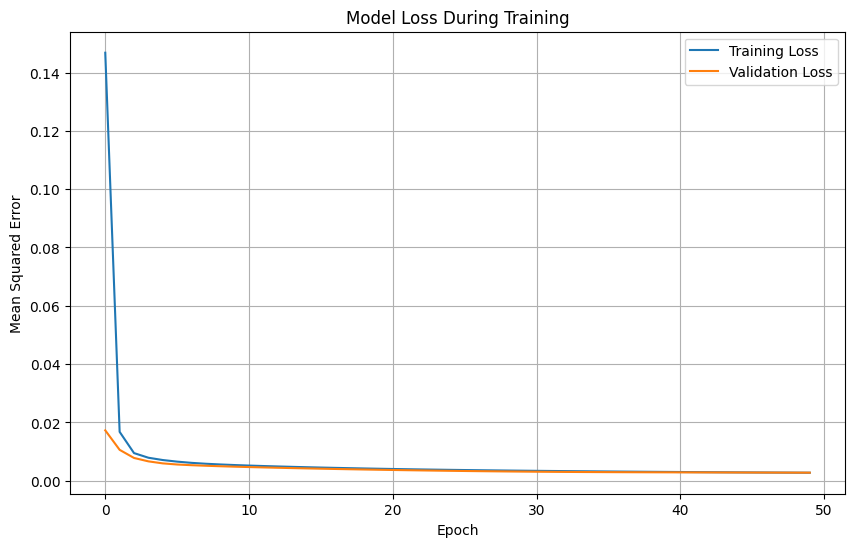

In [11]:
plot_training_history(history)

In [12]:
visualize_predictions(model, X_test, y_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step

Predictions vs Actual Values:
Example 1:
Input sequence: [0.42312383 0.4351206  0.423481   0.49972483 0.53569357 0.54381261
 0.46086669 0.56141654 0.59816929]
Predicted value: 0.6352
Actual value: 0.5905
Error: 0.0447
--------------------------------------------------
Example 2:
Input sequence: [0.89307056 0.81895072 0.78138345 0.97268777 1.05327856 1.11020866
 1.28016954 1.31673205 1.36814269]
Predicted value: 1.5068
Actual value: 1.4664
Error: 0.0404
--------------------------------------------------
Example 3:
Input sequence: [0.52762262 0.47473745 0.5020659  0.60650257 0.65204199 0.68986232
 0.8003747  0.8035608  0.84729983]
Predicted value: 0.9303
Actual value: 0.9108
Error: 0.0195
--------------------------------------------------
Example 4:
Input sequence: [0.58090122 0.51613829 0.45676063 0.56916289 0.62413291 0.6078327
 0.7006694  0.76806205 0.79687792]
Predicted value: 0.8559
Actual value: 0.8828
Error: 0.0269
--------------------------